In [ ]:
# Android Malware Detection with LAMDA (Analisi Concept Drift)

# Questo notebook dimostra come caricare, esplorare e utilizzare il dataset LAMDA
# per la rilevazione di malware Android, concentrandosi sull'analisi del concept drift
# attraverso l'addestramento del modello su 3 anni consecutivi e il test sull'anno successivo.

# 1. Setup e Installazione delle Librerie Necessarie
# Assicurati di avere queste librerie installate nel tuo ambiente Python.
# Puoi installarle decommentando e eseguendo le seguenti righe:
#!pip install datasets
#!pip install huggingface_hub[hf_xet]
#!pip install pandas scikit-learn numpy matplotlib
#!pip install scipy
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 # Per PyTorch con CUDA 11.8
                                                                                              # Sostituisci cu118 con la tua versione CUDA o cpu
import pandas as pd
import numpy as np
from datasets import load_dataset, load_from_disk
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)
import time
import matplotlib.pyplot as plt
import gc # Importa il garbage collector per la gestione della memoria
import os # Per controllare l'esistenza dei file
import shutil # Aggiunto shutil per la copia dei file

# Importazioni per PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset as TorchDataset
from scipy.sparse import csr_matrix, save_npz, load_npz, vstack # AGGIUNTO vstack
# Importa per la compatibilità con scikit-learn BaseEstimator
import sklearn.base

print("Librerie caricate con successo.")

# Determina il dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzo del dispositivo: {device}")

# Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- CONFIGURAZIONE PER IL CARICAMENTO DA GOOGLE DRIVE ---
# INSERISCI QUI IL PERCORSO ALLA CARTELLA DOVE HAI SALVATO I FILE CSV DEL 2022
DRIVE_2022_PATH = '/content/drive/MyDrive/lamda_dataset_2022'
# ---------------------------------------------------------

# --- PARAMETRO DI SOTTOCAMPIONAMENTO GLOBALE ---
# Imposta la frazione di dati da campionare per ogni anno.
# Ad esempio, 0.1 per usare il 10% dei dati. Imposta a 1.0 per usare tutti i dati.
SAMPLE_FRACTION = 0.1 # Come suggerito dal professore per gestire la memoria
# -----------------------------------------------

# --- DEFINIZIONE DEGLI ANNI PER L'ANALISI SPECIFICA ---
TRAIN_YEARS = [2013, 2014, 2016] # Esempio: addestra su 3 anni
TEST_YEAR = 2022 # Esempio: testa sull'anno successivo al periodo di training
# -------------------------------------------------------


Librerie caricate con successo.
Utilizzo del dispositivo: cuda
Mounted at /content/drive


In [ ]:
# Prepara feature e label (necessario per definire feature_cols)
# Carica un piccolo campione per ottenere i nomi delle colonne
# Questo evita di caricare l'intero dataset solo per i nomi delle feature
print("\nCaricamento di un piccolo campione per identificare le feature...")
try:
    # Carica da Hugging Face, non da disco
    sample_hf_dataset = load_dataset('IQSeC-Lab/LAMDA', 'Baseline', split='train').select(range(10))
    metadata_cols = ['hash', 'label', 'family', 'vt_count', 'year_month']
    feature_cols = [col for col in sample_hf_dataset.column_names if col not in metadata_cols]
    del sample_hf_dataset
    gc.collect()
except Exception as e:
    print(f"Errore durante il caricamento del campione per le feature: {e}")
    print("Assicurati che il percorso del dataset sia corretto e che i file siano presenti.")
    feature_cols = [f'feature_{i}' for i in range(4561)] # Esempio di feature_cols placeholder
    print("Utilizzo di un set di feature placeholder. Potrebbe causare errori successivi.")

print(f"\nNumero totale di feature: {len(feature_cols)}")
print(f"Esempio di feature: {feature_cols[:5]}...")



Caricamento di un piccolo campione per identificare le feature...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Baseline/2013/2013_train.parquet:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

Baseline/2014/2014_train.parquet:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Baseline/2016/2016_train.parquet:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Baseline/2017/2017_train.parquet:   0%|          | 0.00/13.4M [00:00<?, ?B/s]

Baseline/2018/2018_train.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Baseline/2019/2019_train.parquet:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

Baseline/2020/2020_train.parquet:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Baseline/2021/2021_train.parquet:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

Baseline/2022/2022_train.parquet:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

Baseline/2023/2023_train.parquet:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

Baseline/2024/2024_train.parquet:   0%|          | 0.00/9.77M [00:00<?, ?B/s]

Baseline/2025/2025_train.parquet:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Baseline/2013/2013_test.parquet:   0%|          | 0.00/5.04M [00:00<?, ?B/s]

Baseline/2014/2014_test.parquet:   0%|          | 0.00/5.44M [00:00<?, ?B/s]

Baseline/2016/2016_test.parquet:   0%|          | 0.00/5.96M [00:00<?, ?B/s]

Baseline/2017/2017_test.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Baseline/2018/2018_test.parquet:   0%|          | 0.00/6.26M [00:00<?, ?B/s]

Baseline/2019/2019_test.parquet:   0%|          | 0.00/6.26M [00:00<?, ?B/s]

Baseline/2020/2020_test.parquet:   0%|          | 0.00/6.89M [00:00<?, ?B/s]

Baseline/2021/2021_test.parquet:   0%|          | 0.00/6.49M [00:00<?, ?B/s]

Baseline/2022/2022_test.parquet:   0%|          | 0.00/6.49M [00:00<?, ?B/s]

Baseline/2023/2023_test.parquet:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Baseline/2024/2024_test.parquet:   0%|          | 0.00/4.71M [00:00<?, ?B/s]

Baseline/2025/2025_test.parquet:   0%|          | 0.00/4.53M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/806700 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/201681 [00:00<?, ? examples/s]

In [ ]:


# Funzione per convertire un Hugging Face Dataset in una matrice sparsa CSR e un array NumPy per le etichette
def hf_dataset_to_sparse_matrix(hf_dataset, feature_cols, label_col='label', sample_fraction=1.0):
    """
    Converts a Hugging Face Dataset to a scipy.sparse.csr_matrix and a numpy array for labels.
    Optionally samples a fraction of the data.
    Assumes binary features (0 or 1).
    """
    if sample_fraction < 1.0:
        num_samples_to_take = int(len(hf_dataset) * sample_fraction)
        if num_samples_to_take == 0 and len(hf_dataset) > 0: # Ensure at least one sample if dataset is not empty
            num_samples_to_take = 1
        if num_samples_to_take == 0: # If dataset is empty or sample_fraction is too small
            return csr_matrix((0, len(feature_cols)), dtype=np.float32), np.array([], dtype=np.int32)

        # Randomly select indices for sampling
        all_indices = list(range(len(hf_dataset)))
        sampled_indices = np.random.choice(all_indices, num_samples_to_take, replace=False)
        hf_dataset = hf_dataset.select(sampled_indices)
        num_samples = len(hf_dataset) # Update num_samples after sampling
    else:
        num_samples = len(hf_dataset)

    if num_samples == 0:
        return csr_matrix((0, len(feature_cols)), dtype=np.float32), np.array([], dtype=np.int32)

    data = []
    indices = [] # Column indices
    indptr = [0] # Pointer to the start of each row in data and indices

    labels = np.zeros(num_samples, dtype=np.int32)

    feature_name_to_idx = {name: i for i, name in enumerate(feature_cols)}

    for i, example in enumerate(hf_dataset):
        labels[i] = example[label_col]
        current_row_indices = []
        for feature_name in feature_cols:
            if example[feature_name] == 1: # Assuming binary features
                data.append(1)
                current_row_indices.append(feature_name_to_idx[feature_name])
        indices.extend(current_row_indices)
        indptr.append(len(data))

    X_sparse = csr_matrix((data, indices, indptr), shape=(num_samples, len(feature_cols)), dtype=np.float32)
    return X_sparse, labels

In [ ]:


# Classe Dataset personalizzata per PyTorch che gestisce l'input sparso
class SparseTensorDataset(TorchDataset):
    def __init__(self, X_sparse, y_array):
        self.X_sparse = X_sparse # scipy.sparse.csr_matrix
        self.y_array = y_array   # numpy array

    def __len__(self):
        return self.X_sparse.shape[0]

    def __getitem__(self, idx):
        # Convert sparse row to dense tensor for the batch
        x = torch.tensor(self.X_sparse[idx].toarray().squeeze(0), dtype=torch.float32)
        y = torch.tensor(self.y_array[idx], dtype=torch.float32).unsqueeze(0)
        return x, y

# Funzione per creare il modello PyTorch (MLP)
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 128)
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.3)
        self.layer_2 = nn.Linear(128, 64)
        self.relu_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.3)
        self.layer_out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.layer_out(x)
        x = self.sigmoid(x)
        return x

# Wrapper per rendere il modello PyTorch compatibile con l'API di scikit-learn
class PyTorchClassifier(sklearn.base.BaseEstimator):
    def __init__(self, input_dim, learning_rate=0.001, epochs=5, batch_size=128, model_state=None, device='cpu'):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.optimizer = None
        self.criterion = nn.BCELoss()
        self.model_state = model_state
        self.device = device

        # Chiamata a set_params per registrare i parametri con BaseEstimator
        self.set_params(input_dim=input_dim, learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, model_state=model_state, device=device)

        if model_state is not None:
            self._initialize_model()

    def _initialize_model(self):
        if self.model is None or (hasattr(self.model, 'layer_1') and self.model.layer_1.in_features != self.input_dim):
            self.model = MLP(self.input_dim).to(self.device)
        if self.model_state:
            self.model.load_state_dict(self.model_state)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def fit(self, X, y):
        # X può essere un array NumPy denso o una matrice sparsa CSR
        if not isinstance(X, (np.ndarray, csr_matrix)):
            raise TypeError("Input X must be a numpy array or scipy.sparse.csr_matrix.")
        if not isinstance(y, np.ndarray):
            raise TypeError("Input y must be a numpy array.")

        if self.model is None:
            self._initialize_model()

        # Crea un dataset personalizzato che gestisce la conversione da sparso a denso per batch
        dataset = SparseTensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model.train()
        for epoch in range(self.epochs):
            for inputs, labels in dataloader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        gc.collect()
        return self

    def _predict_with_dataloader(self, X):
        if self.model is None:
            raise RuntimeError("Il modello non è stato ancora addestrato (fit non chiamato).")
        self.model.eval()

        # Crea un DataLoader per la previsione
        class PredictionDataset(TorchDataset):
            def __init__(self, X_sparse):
                self.X_sparse = X_sparse
            def __len__(self):
                return self.X_sparse.shape[0]
            def __getitem__(self, idx):
                return torch.tensor(self.X_sparse[idx].toarray().squeeze(0), dtype=torch.float32)

        dataset = PredictionDataset(X)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        all_outputs = []
        with torch.no_grad():
            for inputs in dataloader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                all_outputs.append(outputs.cpu().numpy())

        return np.vstack(all_outputs)

    def predict_proba(self, X):
        outputs = self._predict_with_dataloader(X)
        return np.hstack((1 - outputs, outputs))

    def predict(self, X):
        outputs = self._predict_with_dataloader(X)
        return (outputs > 0.5).astype(int)

    def get_model_state(self):
        if self.model:
            return self.model.state_dict()
        return None

    def get_params(self, deep=True):
        return {
            'input_dim': self.input_dim,
            'learning_rate': self.learning_rate,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'model_state': self.model_state,
            'device': self.device
        }



In [ ]:
# Funzione per caricare i dati di un anno specifico dallo split Hugging Face (OTTIMIZZATA)
# Ora accetta un oggetto dataset_hf_obj obbligatorio e sample_fraction.
def get_data_for_year_hf(year, split_type, feature_cols, metadata_cols, dataset_hf_obj, sample_fraction=1.0):
    print(f"  Caricamento dati {split_type} per l'anno {year} da Hugging Face (ottimizzato, campionamento={sample_fraction*100:.0f}%)...")

    filtered_dataset = dataset_hf_obj[split_type].filter(
        lambda example: example['year_month'].startswith(str(year)),
        num_proc=os.cpu_count()
    )

    if len(filtered_dataset) == 0:
        print(f"  Nessun dato trovato per {split_type} nell'anno {year} da Hugging Face.")
        return csr_matrix((0, len(feature_cols)), dtype=np.float32), np.array([], dtype=np.int32)

    # Converti il subset filtrato in matrice sparsa con campionamento
    X_sparse, labels = hf_dataset_to_sparse_matrix(filtered_dataset, feature_cols, sample_fraction=sample_fraction)

    del filtered_dataset # Rimuovi i riferimenti per aiutare il GC
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()

    return X_sparse, labels

In [ ]:



# 4. Caricamento del Dataset LAMDA Completo e Inizio Analisi del Concept Drift
# Carica l'oggetto dataset da Hugging Face QUI, solo quando necessario per l'analisi multi-anno.
print("\nCaricamento del dataset LAMDA (configurazione 'Baseline') per analisi multi-anno...")
start_time = time.time()
dataset_hf = load_dataset('IQSeC-Lab/LAMDA', 'Baseline')
end_time = time.time()
print(f"Dataset caricato in {end_time - start_time:.2f} secondi.")
print(f"Split disponibili: {dataset_hf.keys()}")

print("\n--- Pre-elaborazione e Salvataggio dei Dati Campionati ---")
# Nomi dei file per salvare i dati pre-elaborati per ogni anno
train_files_exist = True
for year in TRAIN_YEARS:
    if not (os.path.exists(f'X_train_{year}_sampled.npz') and os.path.exists(f'y_train_{year}_sampled.npy')):
        train_files_exist = False
        break

X_TEST_FILE = 'X_test_sampled.npz'
Y_TEST_FILE = 'y_test_sampled.npy'
test_files_exist = os.path.exists(X_TEST_FILE) and os.path.exists(Y_TEST_FILE)

if train_files_exist and test_files_exist:
    print("Tutti i dati campionati trovati in locale. Caricamento dai file...")
else:
    print("Dati campionati non trovati in locale. Caricamento, campionamento e salvataggio...")
    for year in TRAIN_YEARS:
        x_file = f'X_train_{year}_sampled.npz'
        y_file = f'y_train_{year}_sampled.npy'
        if not (os.path.exists(x_file) and os.path.exists(y_file)):
            print(f"  Pre-elaborazione e salvataggio dati per l'anno {year}...")
            X_year_train, y_year_train = get_data_for_year_hf(year, 'train', feature_cols, metadata_cols, dataset_hf_obj=dataset_hf, sample_fraction=SAMPLE_FRACTION)
            if X_year_train.shape[0] > 0:
                save_npz(x_file, X_year_train)
                np.save(y_file, y_year_train)
                print(f"  Dati di training per l'anno {year} salvati in locale.")
            else:
                print(f"  ATTENZIONE: Nessun dato trovato per l'anno {year}, non è stato salvato nessun file.")
            del X_year_train, y_year_train
            gc.collect()

    if not (os.path.exists(X_TEST_FILE) and os.path.exists(Y_TEST_FILE)):
        print(f"  Pre-elaborazione e salvataggio dati per l'anno di test {TEST_YEAR}...")
        X_test_curr, y_test_curr = get_data_for_year_hf(TEST_YEAR, 'test', feature_cols, metadata_cols, dataset_hf_obj=dataset_hf, sample_fraction=SAMPLE_FRACTION)
        if X_test_curr.shape[0] > 0:
            save_npz(X_TEST_FILE, X_test_curr)
            np.save(Y_TEST_FILE, y_test_curr)
            print("  Dati di test salvati in locale.")
        else:
            print(f"  ATTENZIONE: Nessun dato trovato per l'anno di test {TEST_YEAR}, non è stato salvato nessun file.")
        del X_test_curr, y_test_curr
        gc.collect()

# Carica i dati separati e combinali per il training
X_train_combined_list = []
y_train_combined_list = []
for year in TRAIN_YEARS:
    x_file = f'X_train_{year}_sampled.npz'
    y_file = f'y_train_{year}_sampled.npy'
    if os.path.exists(x_file) and os.path.exists(y_file):
        X_train_combined_list.append(load_npz(x_file))
        y_train_combined_list.append(np.load(y_file))
    else:
        print(f"ATTENZIONE: File non trovato per l'anno {year}. Lo skipping.")

if not X_train_combined_list:
    raise ValueError(f"Nessun dato di training disponibile per gli anni {TRAIN_YEARS}. Impossibile procedere.")

X_train_combined = vstack(X_train_combined_list)
y_train_combined = np.concatenate(y_train_combined_list)

# Carica i dati di test
X_test_curr = load_npz(X_TEST_FILE)
y_test_curr = np.load(Y_TEST_FILE)

print(f"Dimensioni dati di training campionati: {X_train_combined.shape}")
print(f"Dimensioni dati di test campionati: {X_test_curr.shape}")

In [ ]:
# --- Ricerca del miglior parametro per la Rete Neurale con GridSearchCV ---
print("\n--- Ricerca del miglior parametro per la Rete Neurale con GridSearchCV ---")
print(f"Utilizzo dei dati di training pre-elaborati per GridSearchCV.")

if X_train_combined.shape[0] == 0:
    print("ATTENZIONE: Nessun dato disponibile per GridSearchCV. Impostazione di parametri predefiniti.")
    best_learning_rate = 0.001
    best_batch_size = 128
    best_epochs = 5
else:
    pytorch_model_wrapper = PyTorchClassifier(input_dim=X_train_combined.shape[1], device=device)

    param_grid = {
        'learning_rate': [0.001, 0.003, 0.005, 0.008, 0.01],
        'batch_size': [16, 32, 64, 96, 128],
        'epochs': [ 5, 10, 15, 20]
    }

    grid_search = GridSearchCV(pytorch_model_wrapper, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # Ridotto n_splits per velocità
                               scoring='f1', n_jobs=-1, verbose=0)
    start_time_gs = time.time()
    grid_search.fit(X_train_combined, y_train_combined)
    end_time_gs = time.time()
    print(f"GridSearchCV completato in {end_time_gs - start_time_gs:.2f} secondi.")
    print(f"Migliori parametri trovati: {grid_search.best_params_}")

    best_learning_rate = grid_search.best_params_['learning_rate']
    best_batch_size = grid_search.best_params_['batch_size']
    best_epochs = grid_search.best_params_['epochs']

    # Non è necessario eliminare X_grid_train_combined, y_grid_train_combined qui
    # perché stiamo riutilizzando X_train_combined e y_train_combined.
    gc.collect()

In [ ]:
# --- FASE DI TRAINING FINALE CON PARAMETRI OTTIMIZZATI ---
#best_learning_rate=0.001
#best_batch_size=16
#best_epochs=10


print("\n--- FASE DI TRAINING FINALE DEL MODELLO ---")
print(f"Addestramento del modello su anni: {TRAIN_YEARS} con parametri ottimizzati.")

final_model = PyTorchClassifier(input_dim=X_train_combined.shape[1],
                                learning_rate=best_learning_rate,
                                batch_size=best_batch_size,
                                epochs=best_epochs,
                                device=device)

start_train_time = time.time()
final_model.fit(X_train_combined, y_train_combined)
end_train_time = time.time()
print(f"Addestramento finale completato in {end_train_time - start_train_time:.2f} secondi.")


--- FASE DI TRAINING FINALE DEL MODELLO ---
Addestramento del modello su anni: [2013, 2014, 2016] con parametri ottimizzati.
Addestramento finale completato in 77.53 secondi.



--- FASE DI TESTING SULL'ANNO 2025 ---

Report di Classificazione:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       893
           1       0.00      0.00      0.00         0

    accuracy                           0.95       893
   macro avg       0.50      0.47      0.49       893
weighted avg       1.00      0.95      0.97       893

Accuratezza per i dati del 2025: 0.9485
Precisione per i dati del 2025: 0.0000
Recall (TPR) per i dati del 2025: 0.0000
F1-Score per i dati del 2025: 0.0000
ROC AUC per i dati del 2025: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zer

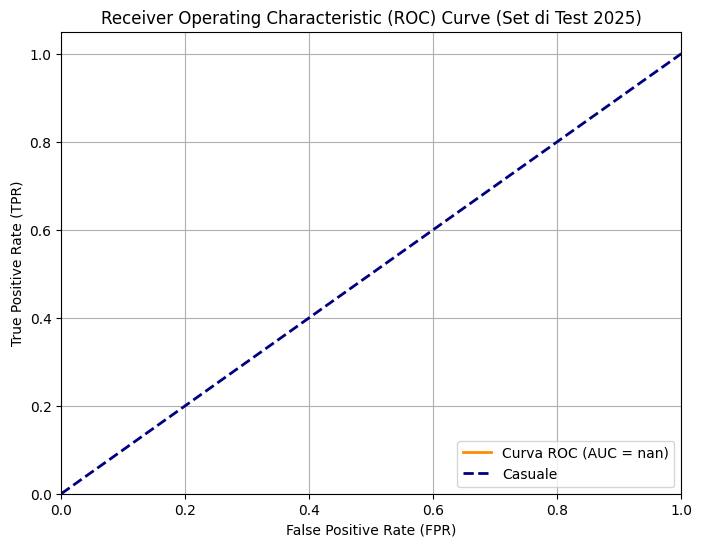


--- Fine Analisi del Concept Drift per la Finestra Specificata ---
Il modello è stato addestrato sugli anni [2013, 2014, 2016] e testato sull'anno 2025.
Questo dimostra un'analisi mirata del concept drift per una specifica finestra temporale.


In [ ]:


# --- FASE DI TESTING ---
print(f"\n--- FASE DI TESTING SULL'ANNO {TEST_YEAR} ---")

if X_test_curr.shape[0] == 0:
    print(f"Nessun dato di test disponibile per l'anno {TEST_YEAR}. Impossibile valutare.")
else:
    y_pred_curr = final_model.predict(X_test_curr)
    y_scores_curr = final_model.predict_proba(X_test_curr)[:, 1]

    acc = accuracy_score(y_test_curr, y_pred_curr)
    f1 = f1_score(y_test_curr, y_pred_curr)
    roc_auc = roc_auc_score(y_test_curr, y_scores_curr)

    print("\nReport di Classificazione:")
    print(classification_report(y_test_curr, y_pred_curr))

    print(f"Accuratezza per i dati del {TEST_YEAR}: {acc:.4f}")
    print(f"Precisione per i dati del {TEST_YEAR}: {precision_score(y_test_curr, y_pred_curr):.4f}")
    print(f"Recall (TPR) per i dati del {TEST_YEAR}: {recall_score(y_test_curr, y_pred_curr):.4f}")
    print(f"F1-Score per i dati del {TEST_YEAR}: {f1:.4f}")
    print(f"ROC AUC per i dati del {TEST_YEAR}: {roc_auc:.4f}")

    # Plot ROC Curve
    fpr_test, tpr_test, _ = roc_curve(y_test_curr, y_scores_curr)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Casuale')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve (Set di Test {TEST_YEAR})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

del X_train_combined, y_train_combined, X_test_curr, y_test_curr, final_model
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

print("\n--- Fine Analisi del Concept Drift per la Finestra Specificata ---")
print(f"Il modello è stato addestrato sugli anni {TRAIN_YEARS} e testato sull'anno {TEST_YEAR}.")
print("Questo dimostra un'analisi mirata del concept drift per una specifica finestra temporale.")
